# Advanced layer types: Sequences and Attention

## Questions

- Why do we need layers specifically designed for sequential data?
- What are Recurrent Neural Networks (RNNs) and LSTMs?
- How does an LSTM "remember” important information over time?
- What are alternatives like attention?:::

## Objectives

- Understand the structure and motivation behind RNN and LSTM layers
- Relate LSTM concepts to earlier architectures (dense, CNN)
- Explore a simple forecasting example using LSTM:::


## Revisiting sunshine hours: Specialized layers for temporal modeling

Yesterday, we predicted today's sunshine hours (in Basel) using weather variables from just yesterday — a one-to-one mapping. Each input was a single day's data.

But what if:

- sunshine patterns depend on the past week, not just one day?
- we want to predict multiple days ahead, not just the next one?

### When is a single lag not enough?

In many real-world tasks, yesterday's data alone isn't sufficient — patterns unfold over time:

- Rainy streaks often last several days
- Cold fronts move gradually, not all at once
- In other domains: heartbeats, language, gestures, and biological sequences like proteins rely on order and context across multiple steps

#### Include mutliple lags manually?
A natural next step is to **include multiple lags manually** as input features. 

For example: add sunshine hours from the last 3 or 7 days as separate columns. 

This can work — but comes with limitations:

- It treats the lags as **unordered features** — the model doesn't know day -1 from day -7
- The number of input features **grows quickly** with longer history windows
- You have to **manually decide which lags to include** — a hyperparameter that may not generalize
- A dense model learns **separate weights for each lag**, so it can't easily recognize repeating or shifting patterns (e.g. a dip on day 2 vs. day 3)

### Modeling sequences explicitly

We want a model that:

- accepts ordered sequences of inputs (e.g. past 7 days)
- learns which parts of the past matter most for predicting present/future
- handles shifting or recurring temporal patterns without handcrafting

## Why recurrent layers?

This is where recurrent neural networks (RNNs) come in. Dense layers are memoryless — they treat all inputs independently. RNNs process one time step at a time and pass hidden state ("memory") forward through the sequence.

- RNNs learn how previous time steps influence the current one
- LSTMs (Long Short-Term Memory networks) are a type of RNN that can remember important information over longer periods

## Goals for Today

- Compare dense vs recurrent models for sequence data  
- Understand how LSTMs retain and update memory  
- Build a model that forecasts sunshine using multiple days of history  

## Discussion Prompt

In yesterday's model, we used just one day's weather to predict the next day's sunshine.  
What might we miss by looking only one day back?  
If we include multiple days, should we flatten them or treat them as a sequence — and why?


In [4]:
import pandas as pd
data = pd.read_csv("https://zenodo.org/record/5071376/files/weather_prediction_dataset_light.csv?download=1")

In [5]:
import pandas as pd

filename_data = "data/weather_prediction_dataset_light.csv"
data = pd.read_csv(filename_data)
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-15.2,-17.0,-13.4,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,-13.7,-15.0,-12.3,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-9.2,-12.5,-5.8,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,-5.6,-7.0,-4.2,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-7.6,-9.4,-5.8,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

window_size = 10

# Drop missing values first so slicing stays aligned
data = data.dropna()

nr_rows = data.shape[0]-window_size
X = data.loc[:nr_rows].drop(columns=["DATE", "MONTH"])
y = data.loc[1:(nr_rows + 1)]["BASEL_sunshine"]

X.shape

(3645, 89)

In [7]:
# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X, y = create_sequences(X_scaled, y_scaled, window_size)

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (3635, 10, 89) | y shape: (3635, 1)


* 1066: The number of training sequences — i.e., how many samples the model will see.

* 30: The window size or memory length — each sample includes 30 time steps of history.

* 89: The number of features per time step — in your case, all columns in data except DATE, MONTH, and BASEL_sunshine.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2908, 10, 89)
(363, 10, 89)
(364, 10, 89)


In [9]:
X.shape

(3635, 10, 89)

In [10]:
import sklearn
print(sklearn.__version__)

1.6.1


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# Define simple (reletively low parameter count and depth) regularized LSTM model
model = keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
164/164 - 6s - 39ms/step - loss: 0.0842 - mae: 0.2352 - val_loss: 0.0663 - val_mae: 0.2168
Epoch 2/100
164/164 - 1s - 8ms/step - loss: 0.0692 - mae: 0.2167 - val_loss: 0.0659 - val_mae: 0.2181
Epoch 3/100
164/164 - 1s - 8ms/step - loss: 0.0687 - mae: 0.2198 - val_loss: 0.0656 - val_mae: 0.2188
Epoch 4/100
164/164 - 1s - 7ms/step - loss: 0.0646 - mae: 0.2150 - val_loss: 0.0632 - val_mae: 0.2136
Epoch 5/100
164/164 - 1s - 7ms/step - loss: 0.0636 - mae: 0.2113 - val_loss: 0.0663 - val_mae: 0.2183
Epoch 6/100
164/164 - 1s - 7ms/step - loss: 0.0665 - mae: 0.2182 - val_loss: 0.0642 - val_mae: 0.2221
Epoch 7/100
164/164 - 2s - 12ms/step - loss: 0.0636 - mae: 0.2134 - val_loss: 0.0618 - val_mae: 0.2160
Epoch 8/100
164/164 - 1s - 7ms/step - loss: 0.0628 - mae: 0.2119 - val_loss: 0.0606 - val_mae: 0.2117
Epoch 9/100
164/164 - 1s - 8ms/step - loss: 0.0627 - mae: 0.2122 - val_loss: 0.0605 - val_mae: 0.2130
Epoch 10/100
164/164 - 2s - 13ms/step - loss: 0.0630 - mae: 0.2119 - val_loss: 0

In [12]:
y_pred = model.predict(X_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Unscale
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Compute real-world MAE and MSE
rmse_unscaled = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"Unscaled Test RMSE: {rmse_unscaled:.4f}")



Unscaled Test RMSE: 3.7748


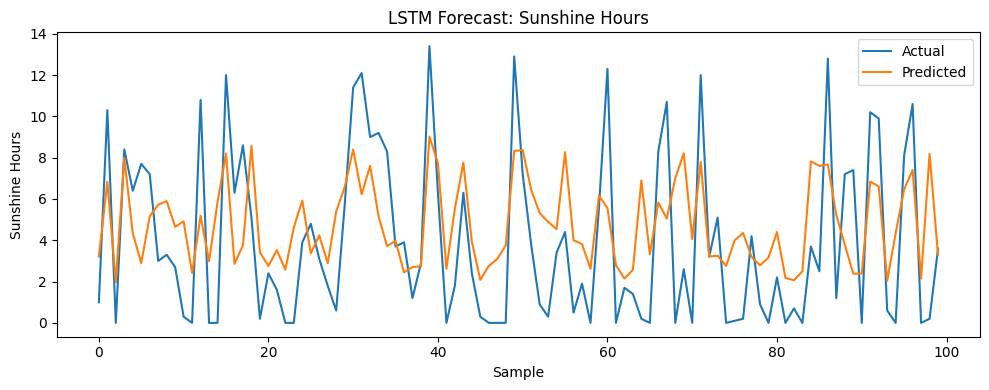

In [15]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_unscaled[:100], label='Actual')
plt.plot(y_pred_unscaled[:100], label='Predicted')
plt.title("LSTM Forecast: Sunshine Hours")
plt.xlabel("Sample")
plt.ylabel("Sunshine Hours")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
from tensorflow import keras
from tensorflow.keras import layers

# Define stacked LSTM model
model = keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.LSTM(64, return_sequences=True),     # First LSTM returns full sequence
    layers.LSTM(32, return_sequences=False),    # Second LSTM returns final output only
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
164/164 - 3s - 21ms/step - loss: 0.2743 - mae: 0.3774 - val_loss: 0.1114 - val_mae: 0.2530
Epoch 2/100
164/164 - 1s - 4ms/step - loss: 0.0912 - mae: 0.2408 - val_loss: 0.0821 - val_mae: 0.2327
Epoch 3/100
164/164 - 1s - 5ms/step - loss: 0.0802 - mae: 0.2305 - val_loss: 0.0687 - val_mae: 0.2294
Epoch 4/100
164/164 - 1s - 4ms/step - loss: 0.0722 - mae: 0.2236 - val_loss: 0.0681 - val_mae: 0.2324
Epoch 5/100
164/164 - 1s - 4ms/step - loss: 0.0709 - mae: 0.2222 - val_loss: 0.0818 - val_mae: 0.2537
Epoch 6/100
164/164 - 1s - 4ms/step - loss: 0.0683 - mae: 0.2191 - val_loss: 0.0692 - val_mae: 0.2296
Epoch 7/100
164/164 - 1s - 9ms/step - loss: 0.0689 - mae: 0.2203 - val_loss: 0.0664 - val_mae: 0.2118
Epoch 8/100
164/164 - 1s - 5ms/step - loss: 0.0662 - mae: 0.2183 - val_loss: 0.1012 - val_mae: 0.2791
Epoch 9/100
164/164 - 1s - 5ms/step - loss: 0.0654 - mae: 0.2176 - val_loss: 0.1189 - val_mae: 0.2821
Epoch 10/100
164/164 - 1s - 5ms/step - loss: 0.0648 - mae: 0.2152 - val_loss: 0.0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unscaled Test RMSE: 3.7157


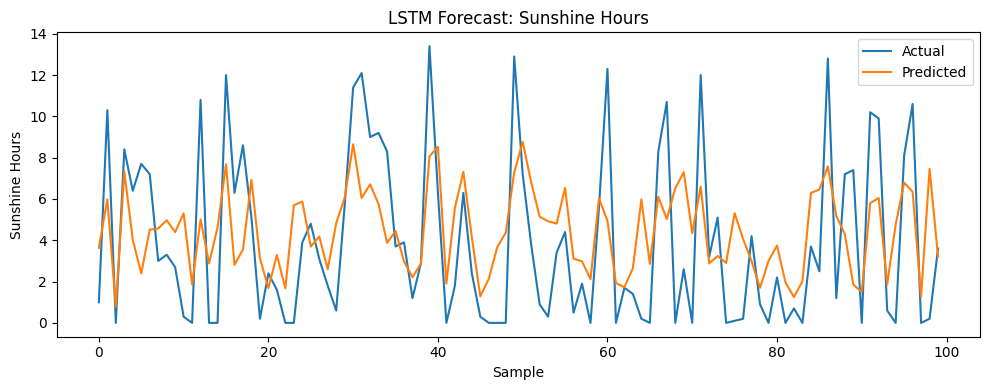

In [51]:
y_pred = model.predict(X_test)

# Unscale
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Compute real-world MAE and MSE
rmse_unscaled = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"Unscaled Test RMSE: {rmse_unscaled:.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_unscaled[:100], label='Actual')
plt.plot(y_pred_unscaled[:100], label='Predicted')
plt.title("LSTM Forecast: Sunshine Hours")
plt.xlabel("Sample")
plt.ylabel("Sunshine Hours")
plt.legend()
plt.tight_layout()
plt.show()


> **Note:** In Episode 3, we included the previous time step's value as an additional input feature.  
> Here, we're building a sequential model (LSTM) that learns from **entire sequences** of prior values, not just a single time step.
> This approach allows the model to learn temporal patterns across longer periods, rather than manually feeding lagged values.


In [ ]:
┌────────────┐
x_t ───►  │  RNN cell  │ ───► h_t
          └────────────┘
            ▲
         h_{t-1}

At each time step t, the RNN takes:
- the input at this step x_t
- the hidden state from the previous step h_{t-1}

It produces a new hidden state h_t, which is used for the next time step and sometimes for prediction.

This creates a short-term memory loop across the sequence.


## The problem with vanilla RNNs

Basic RNNs can capture short-term dependencies, but they struggle to retain information across long sequences — a limitation known as the vanishing gradient problem.

Imagine trying to predict the next word in a sentence:

> I grew up in France… I speak fluent ___.

You want the model to remember "France" — even if it happened many steps earlier. Vanilla RNNs often forget these long-range dependencies.



## LSTM to the rescue

LSTM (Long Short-Term Memory) layers address this by adding a memory component: the cell state.

In [ ]:
#           ┌────────────┐
# x_t ───►  │  LSTM cell │ ───►   h_t
#           └────────────┘
#             ▲       ▲
#         h_{t-1}   c_{t-1} (memory)

At each time step t, the LSTM takes:
- the input x_t
- the previous hidden state h_{t-1}
- the previous cell state c_{t-1}

The cell state acts as long-term memory, while the hidden state provides a short-term summary. Gates inside the LSTM control how much information to forget, store, or expose.

- **Forget gate**: What information should be erased from memory?
- **Input gate**: What new information should be stored?
- **Output gate**: What part of the memory should be passed forward?

This lets the model maintain a persistent internal state across many steps.

Unlike CNNs, LSTMs are not spatially structured, but **temporally structured**: they are great for time, text, or biological sequences.


## LSTM example: Forecasting temperature

Let's use the daily minimum temperature dataset from Melbourne (1981–1990).

Train a basic LSTM model:


### Challenge: Try a Different Memory Length

Try changing the `window_size` from 30 to a different value (e.g., 7, 60, 90).  
What happens to the model's performance? Is it more accurate with shorter or longer memory?

Tip: Try to reason about seasonality and what kind of patterns the model might need to capture.



Note: Unlike Episode 3 where we added a single lag manually, here we specify how many previous time steps the model should consider.  
This is controlled by the `window_size` parameter, which defines the memory length the LSTM sees at each training step.

Changing this window allows us to tune how much historical context the model can use.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(32, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=16)

## Tying it back to earlier episodes

| Episode | What we did              | How LSTM builds on it                     |
|--------|--------------------------|-------------------------------------------|
| Dense  | Connected all inputs     | Still used inside LSTM layers             |
| CNN    | Shared filters for space | LSTM shares memory over time              |
| Dropout| Prevent overfitting      | Also used inside LSTM to regularize       |
| Optimizer | Used Adam              | Same optimizer, but gradients are harder  |


## Attention: A preview

LSTMs read inputs in order. But **attention** allows the model to "look around” the input and learn which parts are important — like reading with a highlighter.

In Keras:

In [ ]:
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization

inputs = Input(shape=(100, 64))
attn_output = MultiHeadAttention(num_heads=2, key_dim=32)(inputs, inputs)
attn_output = LayerNormalization()(inputs + attn_output)

You don't have to understand this fully yet — just know that **attention** is a different strategy for processing sequences, used in Transformers and large language models (LLMs).



::: challenge
What are examples of sequence data in your domain?
- What would be a reasonable input representation?
- Would the order matter?
- Would a CNN, dense model, or LSTM make the most sense?
:::

## Keypoints

- RNNs and LSTMs allow neural networks to process data step-by-step
- LSTMs retain long-term context using gated memory
- Sequence models are widely used in time series, language, and biology:::